In [2]:
from sklearn.datasets import fetch_20newsgroups
import pandas as pd
from nltk import tokenize
import nltk
import matplotlib.pyplot as plt
from wordcloud import WordCloud, ImageColorGenerator
import re
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from collections import defaultdict

from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve
import random

* We will load the dataset using the sklearn `fetch_20newsgroups` function

In [3]:
newsgroups_train = fetch_20newsgroups(subset='train')
newsgroups_test = fetch_20newsgroups(subset='test')

In [8]:
# There are about 11k train data and 7.5k test data (emails containing the new summary).
print(f" Train data contains {len([newsgroups_train.target_names[index] for index in newsgroups_train.target])} data points")
print(f" Test data contains {len([newsgroups_train.target_names[index] for index in newsgroups_test.target])} data points")

 Train data contains 11314 data points
 Test data contains 7532 data points


* View one sample data

In [9]:
# Data
print(newsgroups_train['data'][0])

From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----







* Now we will create data frames and do some preprocessing like removing whitespaces, removing header from each datapoint

In [13]:
train_df = pd.DataFrame({'data':['\n'.join(list(filter(lambda x: x != '', data.split('\n')[5:]))) 
                                 for data in newsgroups_train['data']],
                         'data_subject':['\n'.join(list(filter(lambda x: 'subject' in x.lower(), data.split('\n'))))[9:]
                                         for data in newsgroups_train['data']],
                         'label_names':[newsgroups_train.target_names[index] for index in newsgroups_train.target],
                         'label':newsgroups_train.target})
test_df = pd.DataFrame({'data':['\n'.join(list(filter(lambda x: x != '', data.split('\n')[5:]))) 
                                 for data in newsgroups_test['data']],
                         'data_subject':['\n'.join(list(filter(lambda x: 'subject' in x.lower(), data.split('\n'))))[9:]
                                         for data in newsgroups_test['data']],
                         'label_names':[newsgroups_test.target_names[index] for index in newsgroups_test.target],
                         'label':newsgroups_test.target})

In [14]:
train_df.head()

,data,data_subject,label_names,label
0,I was wondering if anyone out there could enl...,WHAT car is this!?,rec.autos,7
1,Organization: University of Washington\nLines:...,SI Clock Poll - Final Call,comp.sys.mac.hardware,4
2,"well folks, my mac plus finally gave up the gh...",PB questions...\nthis is a real subjective que...,comp.sys.mac.hardware,4
3,NNTP-Posting-Host: amber.ssd.csd.harris.com\nX...,Re: Weitek P9000 ?,comp.graphics,1
4,"From article <C5owCB.n3p@world.std.com>, by to...",Re: Shuttle Launch Question,sci.space,14


* Till now we have just prepared the data to be suitable for futher preprocessing steps, now we will will use it to remove the email id, stopwords, create tokens(divide the entire news summary into tokens(words)) .
> In order add more words to stopwords list in nltk use `stopwords_list.extend(['wordA', 'wordB'])` .

In [15]:
stopwords_list = stopwords.words('english')
def remove_stopwords(sent):
    final_sent = ''
    for word in sent.split(' '):
        if word not in stopwords_list:
            final_sent += word
            final_sent += ' '
    final_sent = re.sub(r'[\w\.-]+@[\w\.-]+', ' ',  final_sent) # remove all email addresses from each datapoint
    return final_sent    

In [16]:
train_df['data'] = train_df.data.apply(lambda x: x.strip().lower()) # removed whitespace and lowercase
train_df['data'] = train_df.data.apply(lambda x: re.sub(r'[^a-zA-Z]', ' ', x)) # removed special chars
train_df['data'] = train_df.data.apply(remove_stopwords) # removed stopwords
train_df['data_tokens'] = train_df.data.apply(tokenize.word_tokenize)


test_df['data'] = test_df.data.apply(lambda x: x.strip().lower()) # removed whitespace and lowercase
test_df['data'] = test_df.data.apply(lambda x: re.sub(r'[^a-zA-Z]', ' ', x)) # removed special chars
test_df['data'] = test_df.data.apply(remove_stopwords) # removed stopwords
test_df['data_tokens'] = test_df.data.apply(tokenize.word_tokenize)

> Saving the data for AWS Sagemaker, the generated files will be uploaded to s3 storage using this [script](https://github.com/prabhupad26/aws-sm-inference-pipline-tutorial/blob/master/newsgroup_classifier/upload_train_data_s3.py)

In [18]:
train_df.to_csv('../newsgroup_classifier/data/train.csv')
test_df.to_csv('../newsgroup_classifier/data/test.csv')

* We will now try to visualize the data to get some insights

In [76]:
# Downloading punkt for tokenization , execute this cell only for  1st run only
nltk.download('punkt')

In [19]:
tokenize_train_data = []
for data in train_df.data.values:
    tokenize_train_data += tokenize.word_tokenize(data)
print(len(tokenize_train_data))

1897170


In [20]:
freq_words = defaultdict(int)
for data in tokenize_train_data:
    freq_words[data]+=1

f_dist = dict(freq_words)
f_dist_dict = dict([(m, n) for m, n in f_dist.items() if n > 3 and len(m) > 2 and n < 100])
f_dist_dict = sorted(f_dist_dict.items(), key= lambda kv: kv[1], reverse=True)
print("Top 10 most frequent words")
print(f_dist_dict[:10])
print("--------------------------")
print("Top 10 least frequent words")
print(f_dist_dict[-10:])

Top 10 most frequent words
[('corner', 99), ('constant', 99), ('wonderful', 99), ('observations', 99), ('survey', 99), ('roman', 99), ('oracle', 99), ('ama', 99), ('screw', 99), ('diego', 99)]
--------------------------
Top 10 least frequent words
[('stds', 4), ('positivity', 4), ('prevalences', 4), ('lilac', 4), ('calloway', 4), ('snijpunten', 4), ('jackman', 4), ('melpar', 4), ('chineham', 4), ('critz', 4)]


* Create a wordcloud to see some visualization of word frequency

In [21]:
wrd = []
for kv in f_dist_dict:
    wrd += ((kv[0]+' ')*kv[1]).split()
len(wrd)

461680

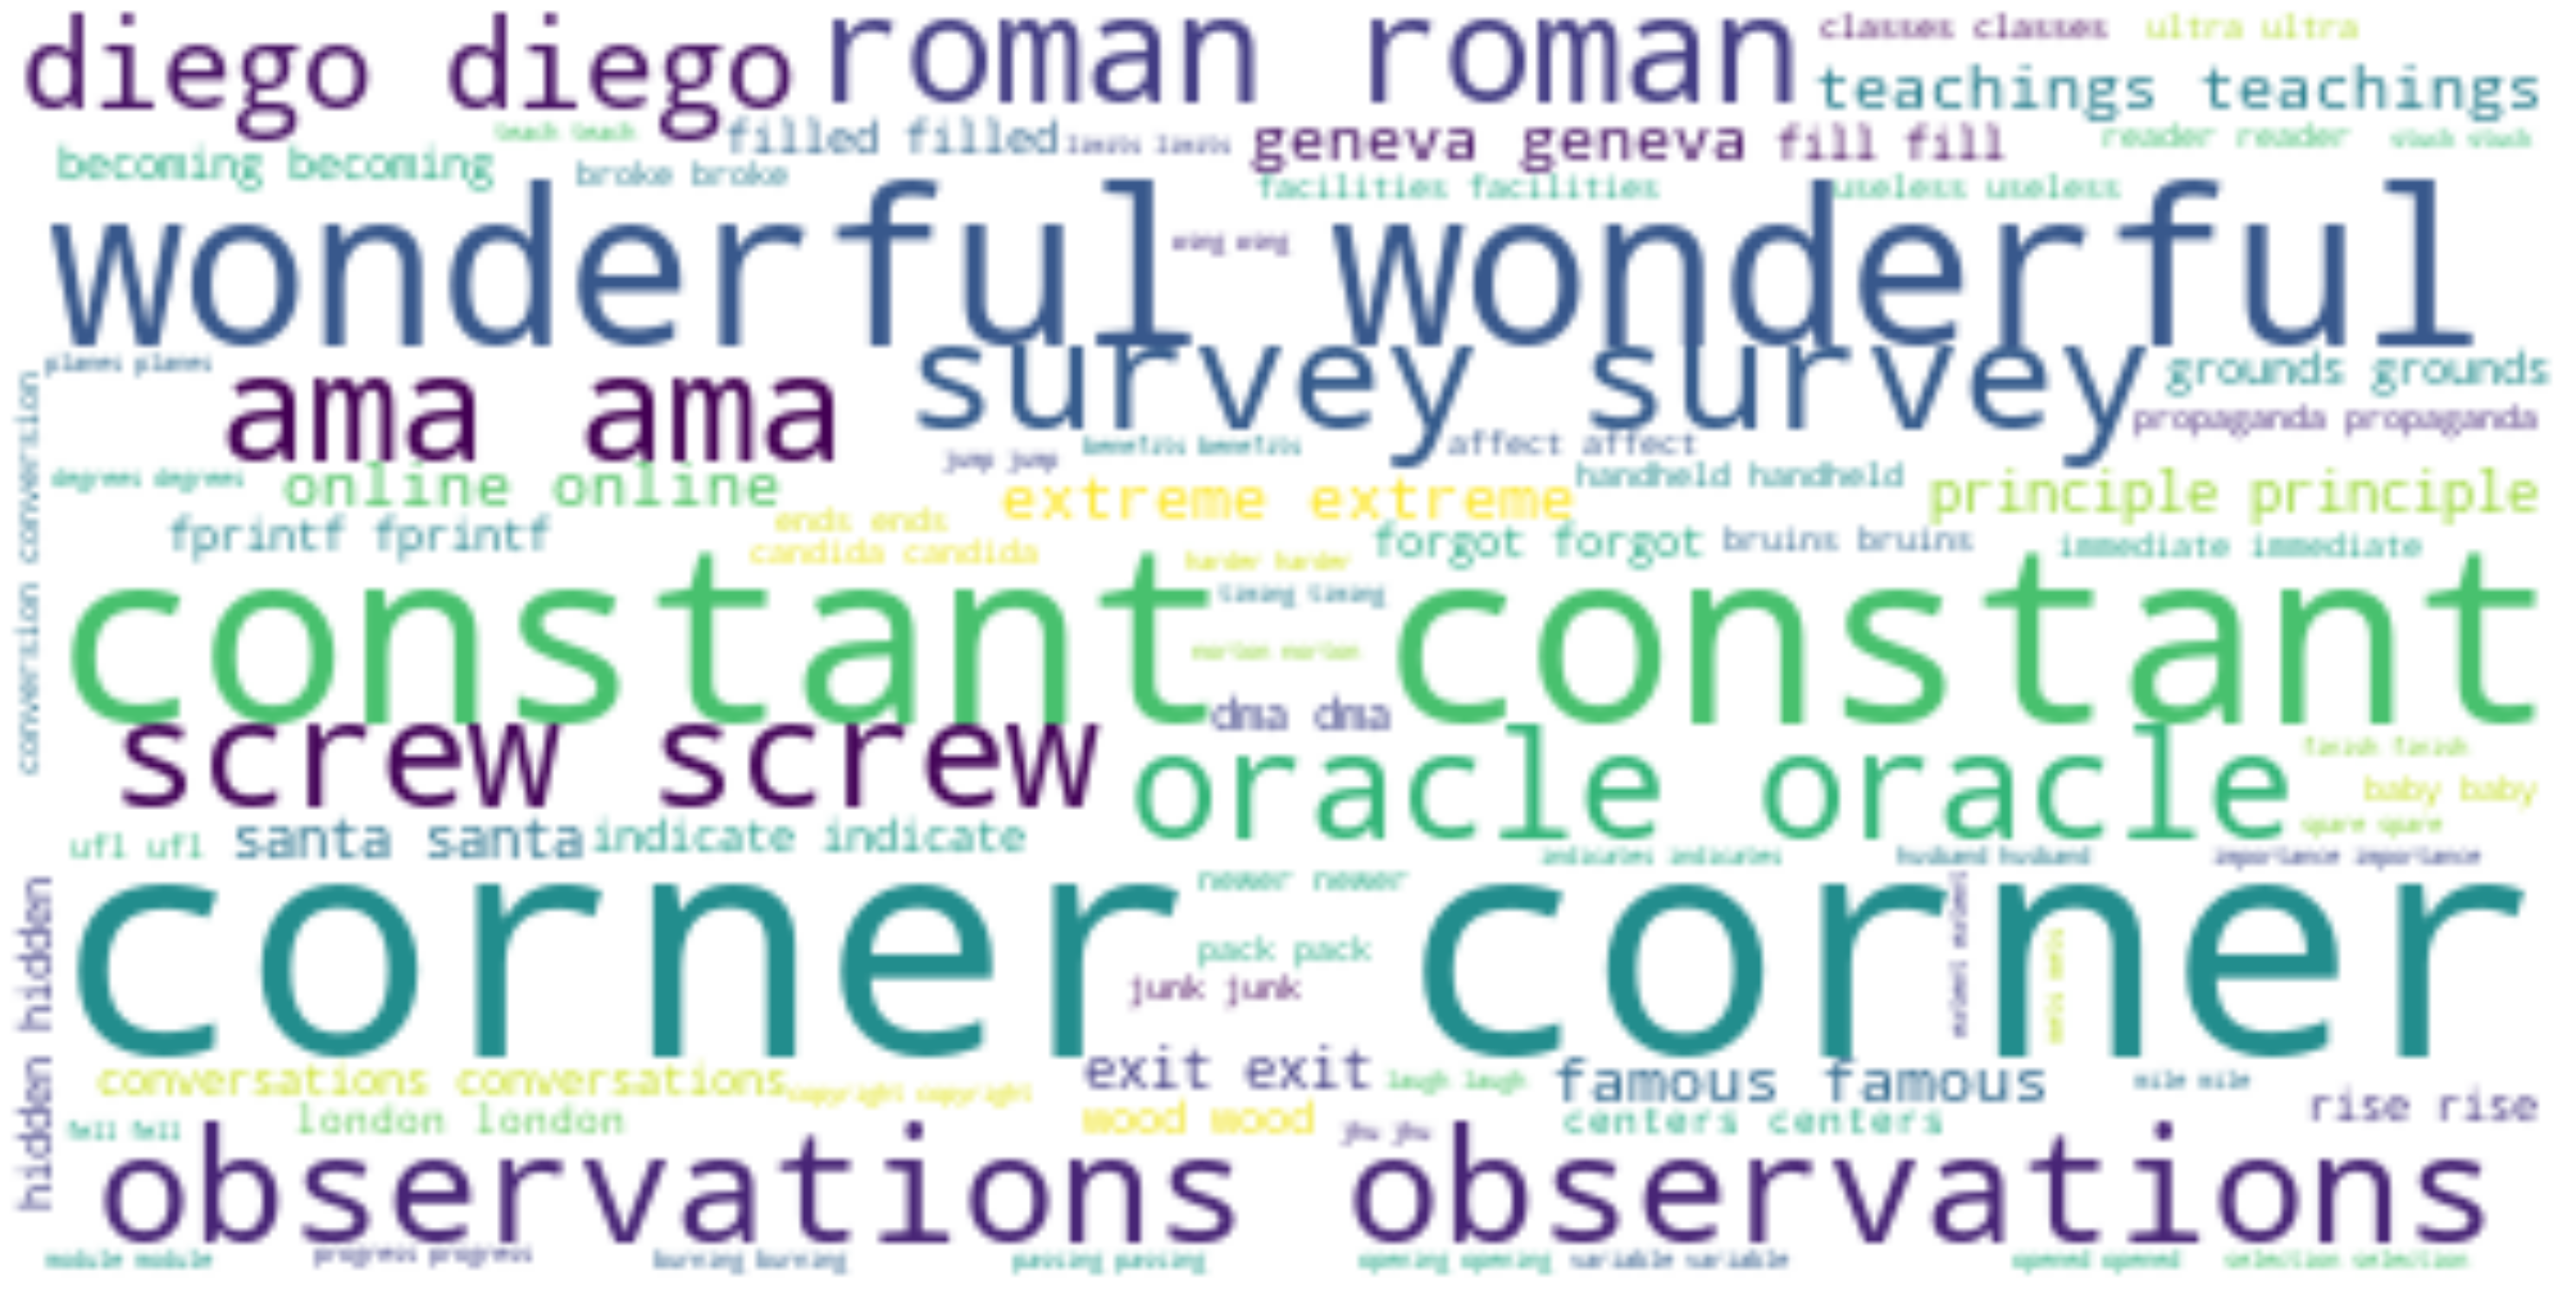

In [22]:
words_cloud_str = ' '.join(wrd)
wordcloud_newsgrp = WordCloud(background_color="white", max_font_size=5000, max_words=30000).generate(words_cloud_str)

plt.figure(figsize = (50,50))
plt.imshow(wordcloud_newsgrp, interpolation='bilinear')
plt.axis("off")
plt.show()

* Create word vectors: TD-IDF word vectors

> Checking how tf-idf matrix is created with sci-kit learn

In [23]:
len(tokenize_train_data)

1897170

In [24]:
vct = TfidfVectorizer()
sample_text = ['this is sent1 and this is sent3 ', 'let\'s see how tf idf will perform', 'let\'s see how tf idf will perform' ]
vctrs = vct.fit_transform(sample_text)
vctrs

<3x12 sparse matrix of type '<class 'numpy.float64'>'
	with 19 stored elements in Compressed Sparse Row format>

In [25]:
sample_text = ['this is sent1 and this is sent3', 'let\'s see how tf idf will perform', 'let\'s see how tf idf will perform' ]
a = []
for i in sample_text:
    a += i.split()
len(set(a))

12

In [26]:
print(f"Total number of non-zero elements per sentence (per row in sparse matrix) are : \033[35m{vctrs.nnz / float(vctrs.shape[0])}")

Total number of non-zero elements per sentence (per row in sparse matrix) are : 6.333333333333333


> Working on train data

In [27]:
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(train_df.data.values)
vectors

<11314x85964 sparse matrix of type '<class 'numpy.float64'>'
	with 1149626 stored elements in Compressed Sparse Row format>

In [29]:
print(f"Total number of non-zero elements per sentence (per row in sparse matrix) are : \033[35m{vectors.nnz / float(vectors.shape[0])}")

Total number of non-zero elements per sentence (per row in sparse matrix) are : 101.61092451829592


In [30]:
import sys
print(f"Memory size occupied by the matrix : \033[35m{sys.getsizeof(vectors)} bytes")

Memory size occupied by the matrix : 48 bytes


In [31]:
vectors_test = vectorizer.transform(test_df.data)
clf = MultinomialNB(alpha=.01)
clf.fit(vectors, train_df.label.values)
pred = clf.predict(vectors_test)
pred

array([ 7, 11,  0, ...,  9, 12, 15])

* Evaluating the model

In [32]:
metrics.f1_score(test_df.label.values, pred, average='macro')

0.8118865539222201

In [33]:
metrics.accuracy_score(y_pred=pred, y_true=test_df.label.values)

0.8187732342007435

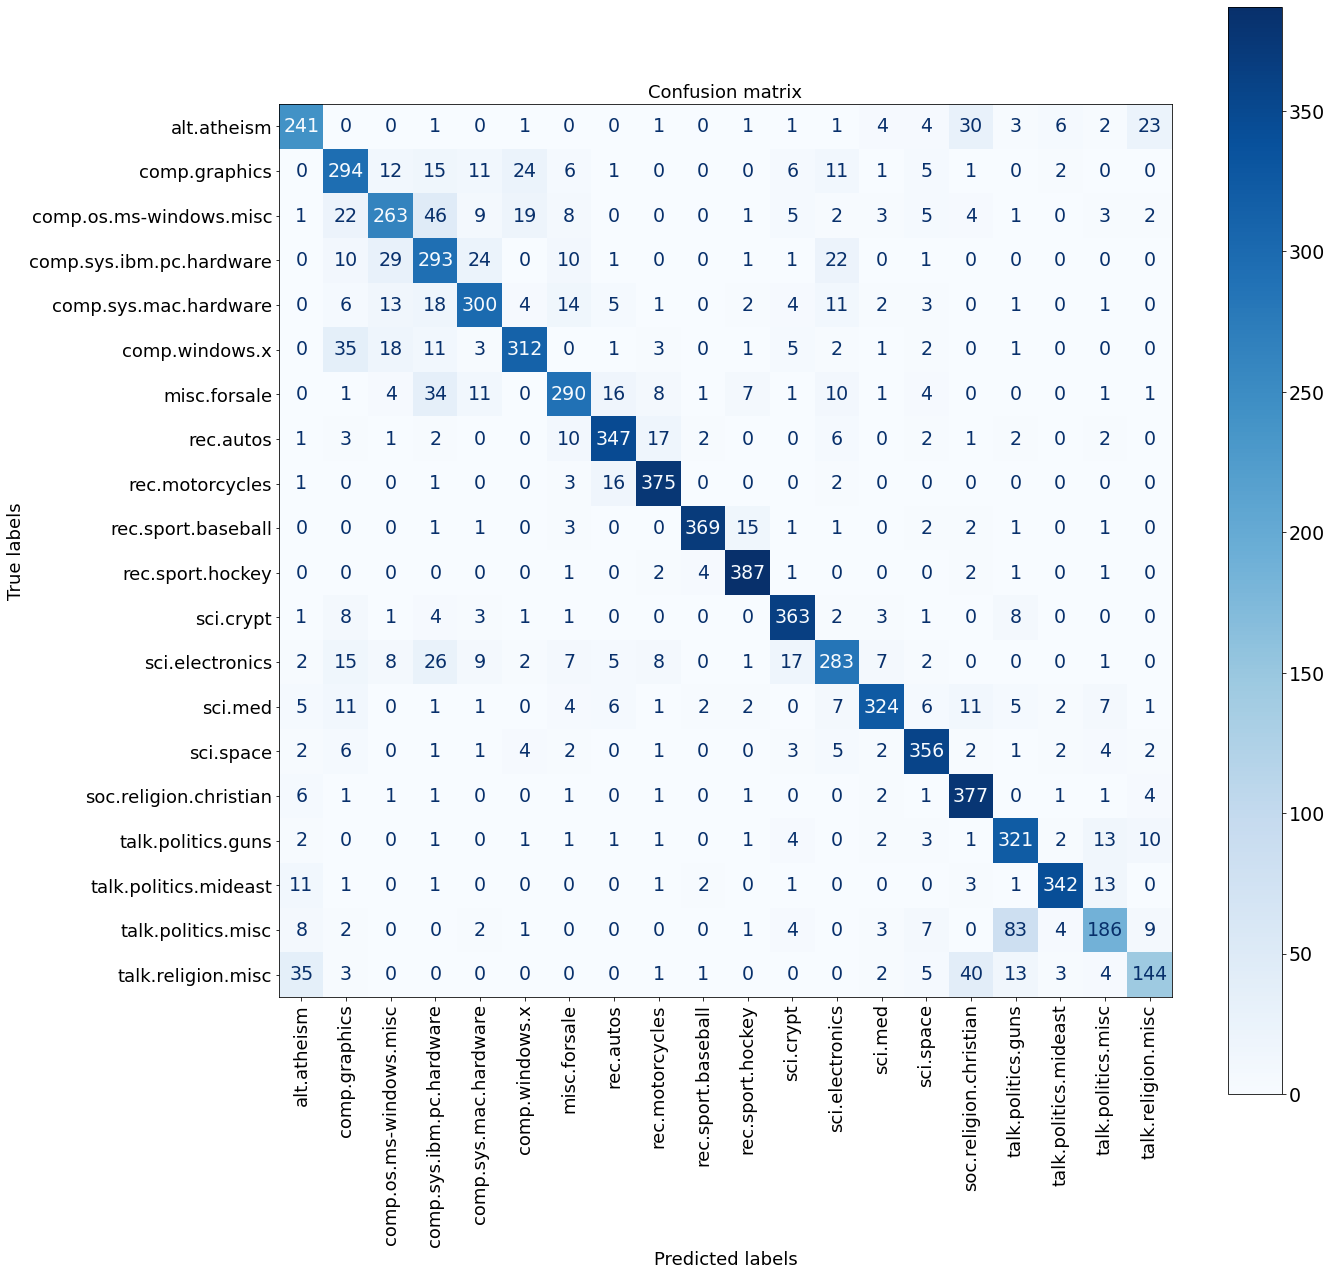

In [35]:
fig, ax = plt.subplots(figsize = (20,20))
disp = metrics.plot_confusion_matrix(clf, vectors_test, test_df.label.values,
                                 cmap=plt.cm.Blues,
                                 display_labels=[train_df.label_names[train_df.label == result_label].values[0]
                                                 for result_label in range(20)],
                                 normalize=None, ax=ax)
disp.ax_.set_title("Confusion matrix", fontsize=18)
plt.rcParams.update({'font.size': 19})
plt.xticks(rotation=90, fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel("Predicted labels", fontsize=18)
plt.ylabel("True labels", fontsize=18)
plt.show()

#### Since this is a multiclass classification so the one vs all ( whether the output is a specific class or not) approach is taken while plotting the confusion matrix, for example there are 241 instances where alt.atheism category is correctly classifies as alt.atheism (True Positive) while the same class is 23 times misinterpreted as talk.religion.misc (False Negative) and talk.religion.misc is 35 times mis classified as alt.atheism (False Positive)

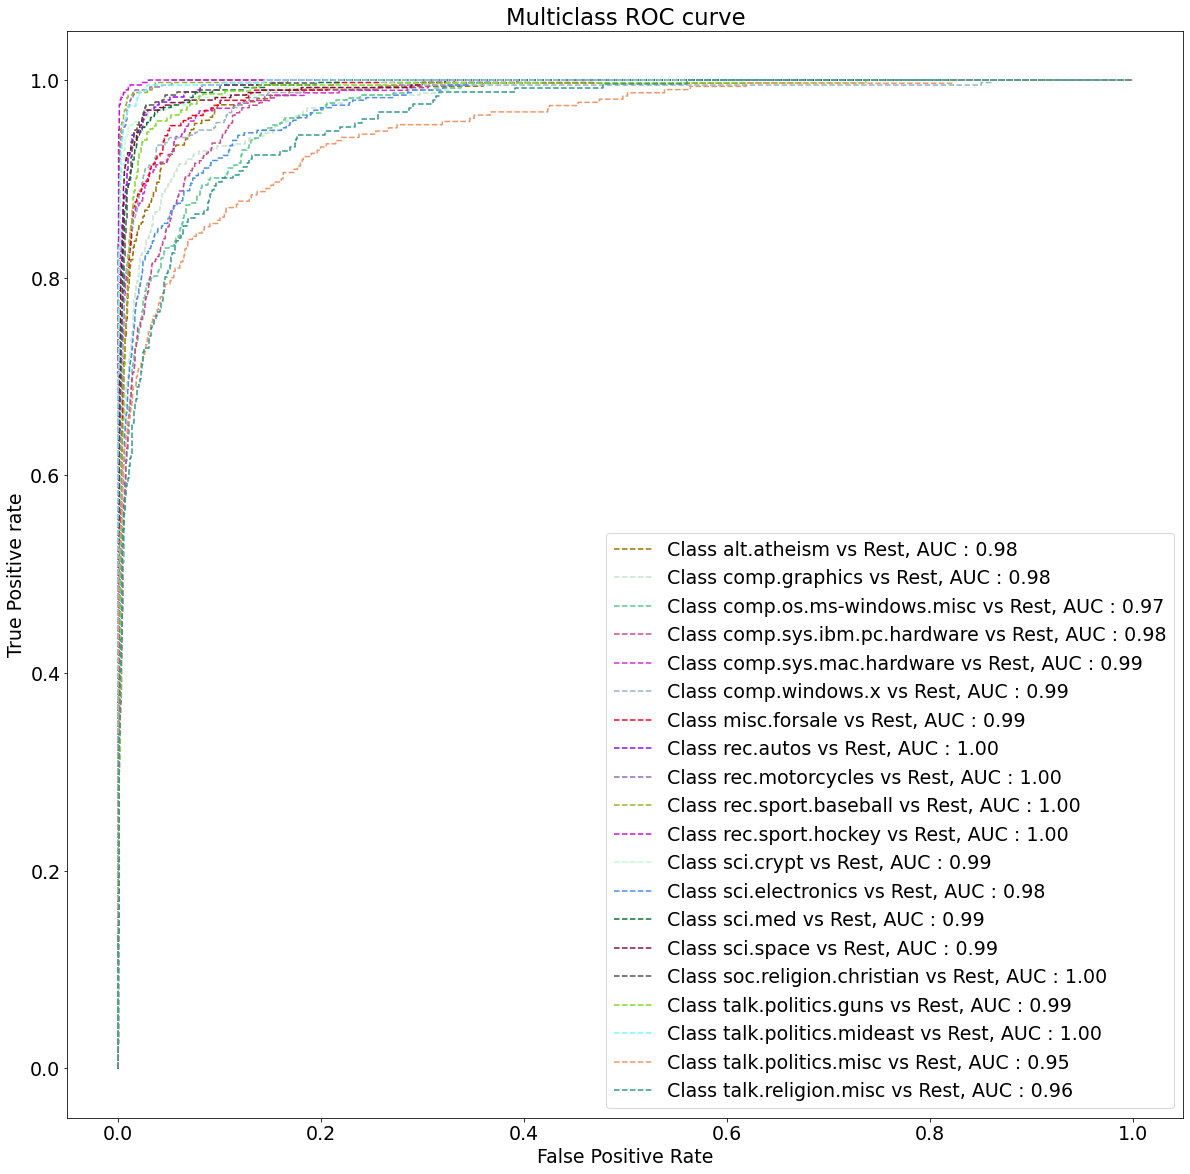

In [36]:
clf_1vrest = OneVsRestClassifier(MultinomialNB(alpha=.01))
clf_1vrest.fit(vectors, train_df.label.values)
pred_prob = clf_1vrest.predict_proba(vectors_test)
fpr = {}
tpr = {}
thresh ={}

n_class = 20

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(test_df.label.values, pred_prob[:,i], pos_label=i)
    
# plotting 
plt.figure(figsize=(20, 20))
for i in range(n_class): 
    r=random.random()
    g=random.random()
    b=random.random()
    plt.plot(fpr[i], tpr[i], linestyle='--',c=(r, g, b),
             label=f'Class {train_df.label_names[train_df.label == i].values[0]} vs Rest, AUC : {metrics.auc(fpr[i], tpr[i]):0.2f}')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC.png',dpi=300)

* The True positive rate (Recall) VS False positive rate (1- specificity) also known as the ROC curve suggests that the model has classified almost every category correctly. 

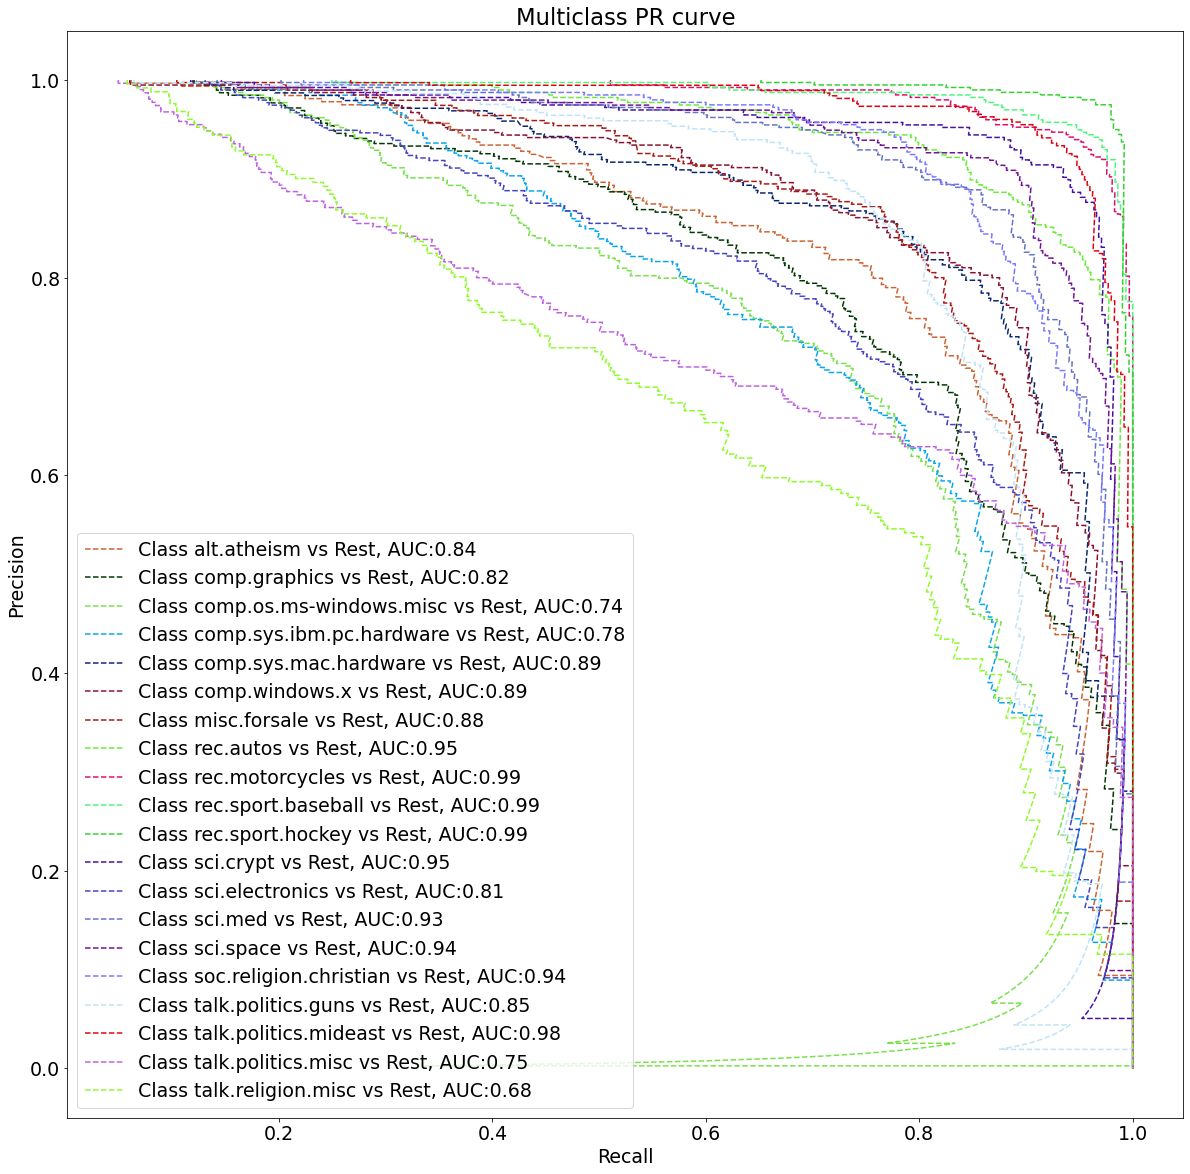

In [93]:
clf_1vrest = OneVsRestClassifier(MultinomialNB(alpha=.01))
clf_1vrest.fit(vectors, train_df.label.values)
pred_prob = clf_1vrest.predict_proba(vectors_test)
pr = {}
recall = {}
thresh ={}

n_class = 20

for i in range(n_class):    
    pr[i], recall[i], thresh[i] = metrics.precision_recall_curve(test_df.label.values, pred_prob[:,i], pos_label=i)
    
# plotting 
plt.figure(figsize=(20, 20))
for i in range(n_class): 
    r=random.random()
    g=random.random()
    b=random.random()
    plt.plot(pr[i], recall[i], linestyle='--',c=(r, g, b), 
             label=f'Class {train_df.label_names[train_df.label == i].values[0]} vs Rest, AUC:{metrics.auc(recall[i], pr[i]):0.2f}')
plt.title('Multiclass PR curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='best')
plt.savefig('Multiclass PRCurve.png',dpi=300)

* From the PR curve it looks there are chances of class imbalance for those categories which has lower Area Under the Curve, so the model could be a bit biased towards the other categories which has greater AUC. This could be avoided by including more data for those categories with less AUC.

In [94]:
sample_input = vectorizer.transform([train_df.data.values[0]])
sample_output = clf.predict(sample_input)
train_df.label_names[train_df.label == sample_output[0]].values[0]

'rec.autos'

In [95]:
train_df.label_names[train_df.label == train_df.label.values[0]].values[0]

'rec.autos'

In [131]:
train_df.label.values[1]

4

In [129]:
train_df.data.values[1]

'organization  university washington lines     nntp posting host  carson u washington edu fair number brave souls upgraded si clock oscillator shared experiences poll  please send brief message detailing experiences procedure  top speed attained  cpu rated speed  add cards adapters  heat sinks  hour usage per day  floppy disk functionality         floppies especially requested  summarizing next two days  please add network knowledge base done clock upgrade answered poll  thanks  guy kuo  guykuo u washington edu  '

In [97]:
train_df.label.values[0]

7

In [98]:
clf.predict(sample_input)

array([7])

In [117]:
import pickle,os
pickle.dump(vectorizer.vocabulary_,open(os.path.join("feature.pkl"),"wb"))

In [106]:
x = TfidfVectorizer(vocabulary=pickle.load(open('feature.pkl', "rb")))

In [114]:
vec = x.fit_transform([train_df.data.values[0]])

In [143]:
type(clf.predict(vec)[0])

numpy.int32

In [133]:
import json
label_dict = {}
for i in range(20): 
    label_dict[i] = train_df.label_names[train_df.label == i].values[0]
with open("label_json.json", 'w') as file:
    json.dump(label_dict, file)

In [134]:
with open("label_json.json", 'r') as file:
    a = json.load(file)

In [137]:
label_dict[4]

'comp.sys.mac.hardware'

In [136]:
label_dict

{0: 'alt.atheism',
 1: 'comp.graphics',
 2: 'comp.os.ms-windows.misc',
 3: 'comp.sys.ibm.pc.hardware',
 4: 'comp.sys.mac.hardware',
 5: 'comp.windows.x',
 6: 'misc.forsale',
 7: 'rec.autos',
 8: 'rec.motorcycles',
 9: 'rec.sport.baseball',
 10: 'rec.sport.hockey',
 11: 'sci.crypt',
 12: 'sci.electronics',
 13: 'sci.med',
 14: 'sci.space',
 15: 'soc.religion.christian',
 16: 'talk.politics.guns',
 17: 'talk.politics.mideast',
 18: 'talk.politics.misc',
 19: 'talk.religion.misc'}

In [140]:
type(vectors)

scipy.sparse.csr.csr_matrix

In [142]:
type(clf)

sklearn.naive_bayes.MultinomialNB